# Visualisation

This notebook contain the codes for creating figures for the CCN 2025 paper.

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xarray as xr

from scipy.signal import sosfiltfilt, butter, sosfilt
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from scipy.signal import welch

import torch
import keras

from scipy.stats import entropy, skew, kurtosis
from scipy.linalg import sqrtm
import mne

def _smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# Feature extraction
def time_domain_features_multi_channel(x, axis=-1):  # x: (n_samples, n_channels, n_timepoints)
    mean = np.mean(x, axis=axis)
    std = np.std(x, axis=axis)
    skewness = skew(x, axis=axis)
    kurtosis_ = kurtosis(x, axis=axis)
    rms = np.sqrt(np.mean(x**2, axis=axis))
    return np.stack([mean, std, skewness, kurtosis_, rms], axis=-1)  # (n_samples, n_channels, n_features)

def hjorth_parameters_multi_channel(signal, axis=-1): 
    activity = np.var(signal, axis=axis)
    first_derivative = np.diff(signal, axis=axis)
    mobility = np.sqrt(np.var(first_derivative, axis=axis) / activity)
    second_derivative = np.diff(first_derivative, axis=axis)
    complexity = np.sqrt(np.var(second_derivative, axis=axis) / np.var(first_derivative, axis=axis)) / mobility
    return np.stack([activity, mobility, complexity], axis=-1)

def spectral_features_multi_channel(signal, fs=128, nperseg=512):
    f, Pxx = welch(signal, fs=fs, nperseg=nperseg, axis=-1)
    total_power = np.sum(Pxx, axis=-1)
    delta = np.sum(Pxx[:, :, (f >= 0.25) & (f < 4)], axis=-1) / total_power
    theta = np.sum(Pxx[:, :, (f >= 4) & (f < 8)], axis=-1) / total_power
    alpha = np.sum(Pxx[:, :, (f >= 8) & (f < 13)], axis=-1) / total_power
    beta = np.sum(Pxx[:, :, (f >= 13) & (f <= 30)], axis=-1) / total_power
    gamma = np.sum(Pxx[:, :, (f > 30) & (f <= 50)], axis=-1) / total_power
    pxx_entropy = entropy(Pxx, axis=-1)
    return np.stack([delta, theta, alpha, beta, gamma, pxx_entropy], axis=-1)


def aggregate_features(real_signal, gen_signal):
    # Extract features
    real_time_features = time_domain_features_multi_channel(real_signal)
    real_hjorth_features = hjorth_parameters_multi_channel(real_signal)
    real_spectral_features = spectral_features_multi_channel(real_signal)
    
    gen_time_features = time_domain_features_multi_channel(gen_signal)
    gen_hjorth_features = hjorth_parameters_multi_channel(gen_signal)
    gen_spectral_features = spectral_features_multi_channel(gen_signal)
    
    # Concatenate features
    real_features = np.concatenate([real_time_features, real_hjorth_features, real_spectral_features], axis=-1)
    gen_features = np.concatenate([gen_time_features, gen_hjorth_features, gen_spectral_features], axis=-1)
    
    # Reshape to 2D for FID
    real_features = real_features.reshape(real_features.shape[0], -1)  # Flatten across channels
    gen_features = gen_features.reshape(gen_features.shape[0], -1)
    
    return real_features, gen_features

# Fréchet Inception Distanc (FID)
def compute_fid(x_features, y_features):
    # Mean and covariance
    mean1, cov1 = x_features.mean(axis=0), np.cov(x_features, rowvar=False)
    mean2, cov2 = y_features.mean(axis=0), np.cov(y_features, rowvar=False)
    # Mean difference
    mean_diff = np.sum((mean1 - mean2)**2)
    
    # Covariance square root
    covmean = sqrtm(cov1 @ cov2)
    
    # Numerical stability
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # FID formula
    fid = mean_diff + np.trace(cov1 + cov2 - 2 * covmean)
    return fid

# DATA & Model

In [2]:
# Real DATA
filtering = True
time_dim = 1024
n_subject = 20
exclude_sub_ids = None
channels = ['O1', 'O2', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2']

# data
data_path = 'data/LEMON_data/EC_8_channels_processed.nc5'
xarray = xr.open_dataarray(data_path, engine='h5netcdf')

x = xarray.sel(subject=xarray.subject[:n_subject])
if exclude_sub_ids is not None:
    x = x.sel(subject=~x.subject.isin(exclude_sub_ids))
    n_subject = len(x.subject)
    sub_ids = xarray.subject[:n_subject].to_numpy()
x = x.to_numpy()

if filtering:
    sos = butter(4, 0.5, btype='high', fs=128, output='sos')
    x = sosfiltfilt(sos, x, axis=-1)
x = torch.tensor(x.copy()).unfold(2, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
sub = torch.tensor(np.arange(0, n_subject).repeat(x.shape[0]//n_subject)[:, np.newaxis])

pos = torch.tensor(xarray.ch_positions[None].repeat(x.shape[0], 0))
data = {'x': x, 'sub': sub, 'pos': pos}

In [4]:
from src.EEGModalNet.models.WGAN import WGAN_GP
latent_dim = 128
model = WGAN_GP(time_dim=1024, feature_dim=len(channels),
                latent_dim=latent_dim, n_subjects=202,
                use_sublayer_generator=True,
                use_sublayer_critic=False,
                use_channel_merger_g=False,
                use_channel_merger_c=False,
                kerner_initializer='random_normal',
                interpolation='bilinear')

# load model and history
chkpoint_dir = 'logs/23.01.2025_epoch_800.model.keras'
model.load_weights(chkpoint_dir)

/opt/homebrew/Caskroom/miniforge/base/envs/MNE/lib/python3.12/site-packages/keras/src/backend/torch/linalg.py:53: UserWarning: The operator 'aten::linalg_qr.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1738206012956/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch.linalg.qr(x, mode=mode)


In [48]:
stats = pd.read_csv('logs/27.01.2025.csv').dropna(axis=1)

# Result 1: Training Stats

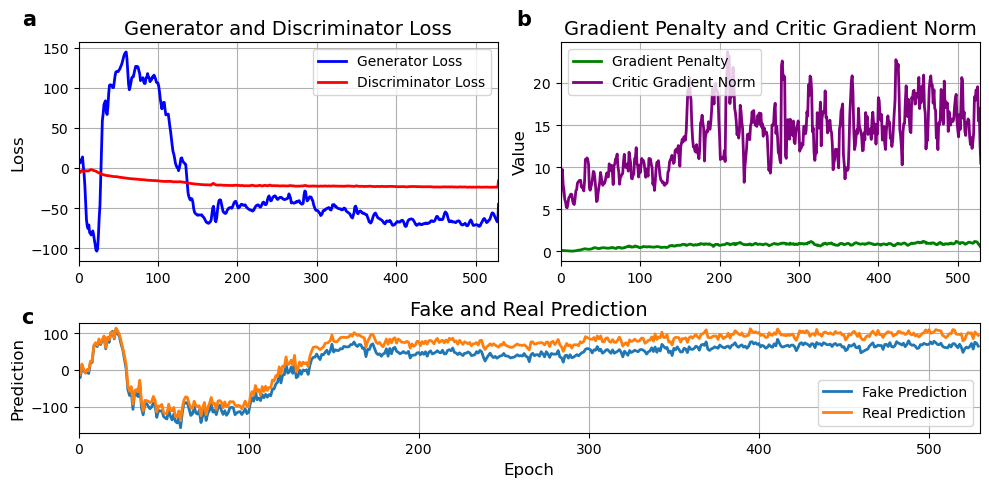

In [49]:
import matplotlib.gridspec as gridspec

lim = len(stats)

# Create a figure
fig = plt.figure(figsize=(10, 5))

# Create a GridSpec with 2 rows and 2 columns
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1], width_ratios=[1, 1])

# First subplot
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(_smooth(stats['g_loss'], 3), label='Generator Loss', color='blue', linestyle='-', linewidth=2)
ax1.plot(_smooth(stats['d_loss'], 3), label='Discriminator Loss', color='red', linestyle='-', linewidth=2)
ax1.legend()
ax1.grid(True)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_xlim([0, lim-2])
ax1.set_title('Generator and Discriminator Loss', fontdict={'fontsize': 14})
ax1.text(-0.1, 1.15, 'a', transform=ax1.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

# Second subplot
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(_smooth(stats['_gp'], 5), label='Gradient Penalty', color='green', linestyle='-', linewidth=2)
ax2.plot(_smooth(stats['critic_grad_norm'], 5), label='Critic Gradient Norm', color='purple', linestyle='-', linewidth=2)
ax2.legend()
ax2.grid(True)
ax2.set_xlim([0, lim-2])
ax2.set_ylabel('Value', fontsize=12)
ax2.set_title('Gradient Penalty and Critic Gradient Norm', fontdict={'fontsize': 14})
ax2.text(-0.07, 1.15, 'b', transform=ax2.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

# Third subplot  # TODO: Add std
ax3 = fig.add_subplot(gs[1, :])
ax3.plot(stats['_fake_pred'], label='Fake Prediction',  linestyle='-', linewidth=2)
ax3.plot(stats['_real_pred'], label='Real Prediction', linestyle='-', linewidth=2)
ax3.legend()
ax3.grid(True)
ax3.set_xlim([0, lim])
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Prediction', fontsize=12)
ax3.set_title('Fake and Real Prediction', fontdict={'fontsize': 14})
ax3.text(-0.05, 1.15, 'c', transform=ax3.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.show()

# Result 2: Compare real and generated data

In [7]:
import mne

def plot_psd_multi_channel(x, c=0, fmin=1, fmax=60, n_fft=512, label='real', show=True, db=True, ax=None):
    _, _, C = x.shape
    if C > 1:
        x = x[:, :, [c]]
    psd, freq = mne.time_frequency.psd_array_welch(x.squeeze().flatten(0, 1).numpy(), sfreq=128, fmin=fmin, fmax=fmax, n_fft=n_fft, verbose=False)
    if db:
        psd = 10*np.log10(psd)
    if ax is not None:
        ax.plot(freq, psd, label=label)
        ax.set_title(f'Channel {channels[c]}')
    else:
        plt.plot(freq, psd, label=label)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density (dB/Hz)')
    if show:
        plt.legend()
        plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/EEGModalNet/lib/python3.11/site-packages/mne/externals/tempita/__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


In [5]:
l = len(x)
x_mean = -4.3159e-06
x_std = 0.4515

x_gen = torch.zeros((l, time_dim, len(channels)))

for i in range(int(l/100)):
    x_gen[i*100:(i+1)*100] = model.generator((keras.random.normal((1, latent_dim), mean=x_mean, stddev=x_std), sub[i].to('mps'), pos[i].to('mps'))).cpu().detach()

## Explore time domain

In [6]:
real_data = x.flatten(0, 1).reshape(n_subject, -1, len(channels))
fake_data = x_gen.flatten(0, 1).reshape(n_subject, -1, len(channels))

### downsampling

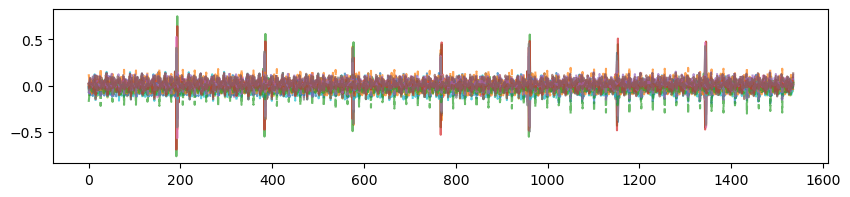

In [91]:
from scipy.signal import resample_poly

downsampled_real = np.array([resample_poly(subj, up=1, down=40) for subj in real_data])
downsampled_fake = np.array([resample_poly(subj, up=1, down=40) for subj in fake_data])

avg_real = np.mean(downsampled_real, axis=0)
avg_fake = np.mean(downsampled_fake, axis=0)

plt.figure(figsize=(10, 2))
plt.plot(avg_real, label="Real (Avg)", alpha=0.7)
plt.plot(avg_fake, label="Generated (Avg)", alpha=0.7, linestyle="dashed")
plt.show()

### plot random data

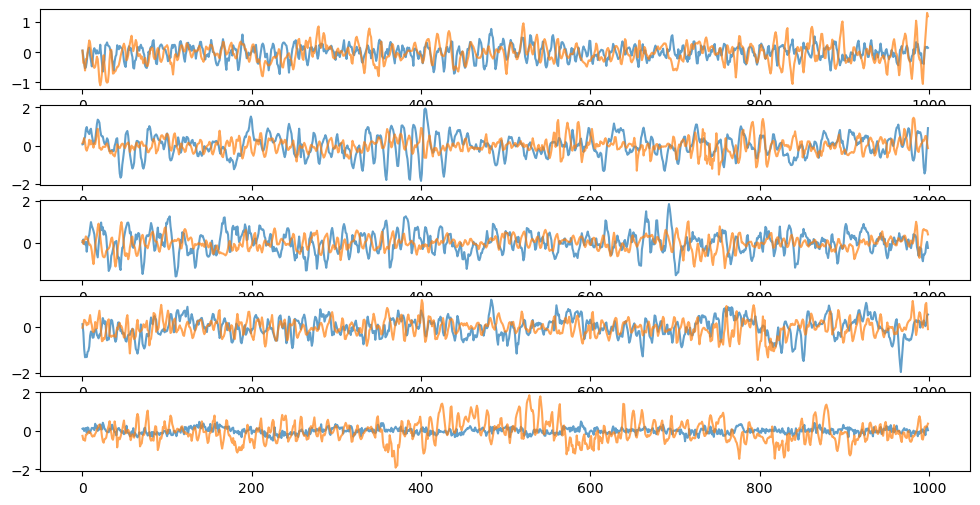

In [39]:
import random

sample_ids = random.sample(range(len(real_data)), 5)  # Pick 5 random participants

ch = 0

plt.figure(figsize=(12, 6))
for i, subj_id in enumerate(sample_ids):
    plt.subplot(5, 1, i + 1)
    plt.plot(real_data[subj_id][:1000, ch], label="Real", alpha=0.7)
    plt.plot(fake_data[subj_id][:1000, ch], label="Generated", alpha=0.7)
    # plt.legend()
plt.show()

### Plot Variability

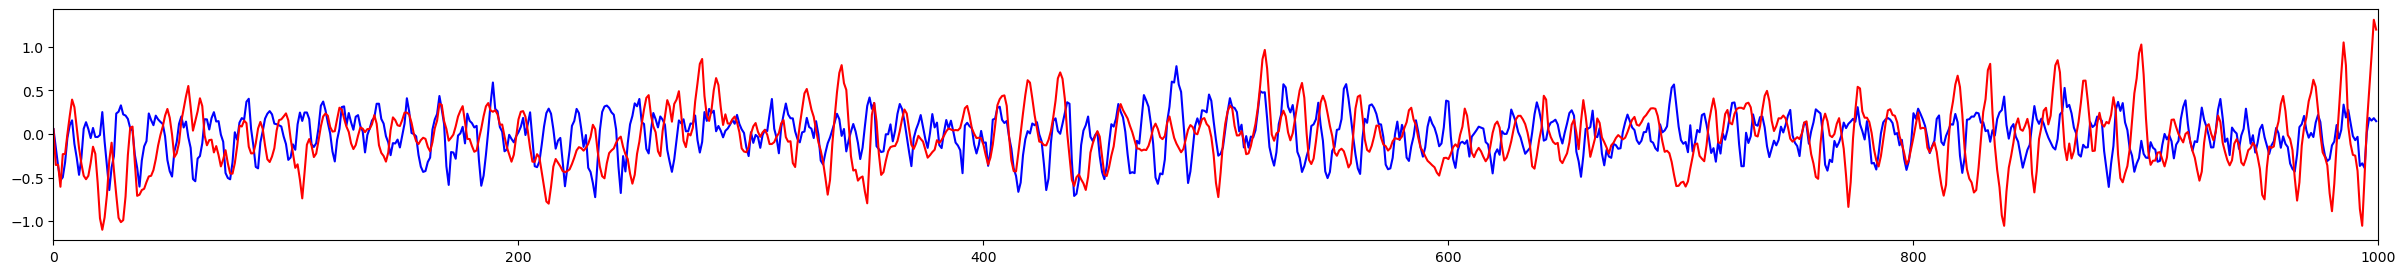

In [56]:
import seaborn as sns

plt.figure(figsize=(30, 3))
sns.lineplot(data=real_data[sample_ids[0], :1000, 0], estimator="mean", errorbar="sd", color="blue")
sns.lineplot(data=fake_data[sample_ids[0], :1000, 0], estimator="mean", errorbar="sd", color="red")
plt.xlim([0, 1000])
plt.show()


### Time-frequency representation

In [104]:
f_real.shape, t_real.shape, Sxx_real.shape

((129,), (8,), (129, 8))

In [102]:
avg_real = real_data.mean(axis=0)[:2000, 0]
avg_fake = fake_data.mean(axis=0)[:2000, 0]

avg_real.shape

torch.Size([2000])

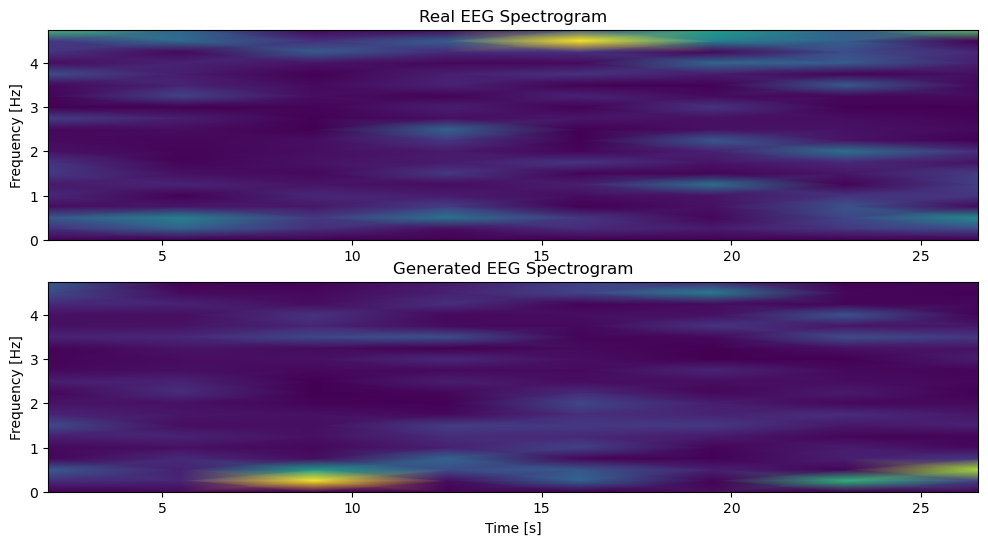

In [114]:
from scipy.signal import spectrogram

f_fake, t_fake, Sxx_fake = spectrogram(avg_fake, fs=64)
f_real, t_real, Sxx_real = spectrogram(avg_real, fs=64)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(t_real, f_real[:20], Sxx_real[:20], shading='gouraud', vmin=Sxx_real.min(), vmax=Sxx_real.max())
plt.title("Real EEG Spectrogram")
plt.ylabel("Frequency [Hz]")

plt.subplot(2, 1, 2)
plt.pcolormesh(t_fake, f_fake[:20], Sxx_fake[:20], shading='gouraud')
plt.title("Generated EEG Spectrogram")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")

plt.show()

### Topomap

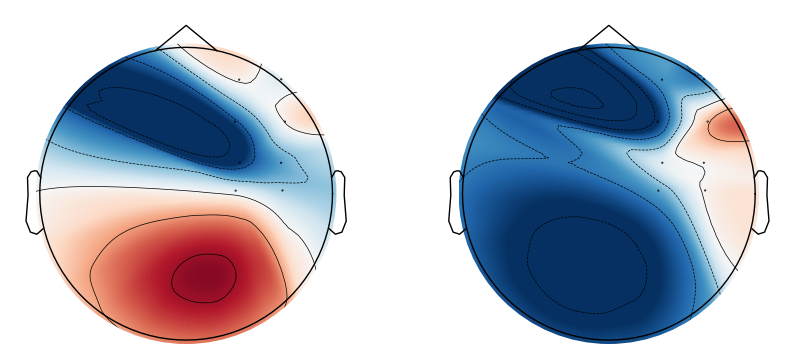

In [12]:
ch_pos = xarray.ch_positions
# compute psd for raw topomap
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
mne.viz.plot_topomap(real_data[2].T.mean(1), ch_pos, show=False, sphere=1, axes=axes[0])
mne.viz.plot_topomap(fake_data[2].T.mean(1), ch_pos, sphere=1, axes=axes[1])
plt.show()

### Plot averaged data over segment dimension

(-0.5, 0.5)

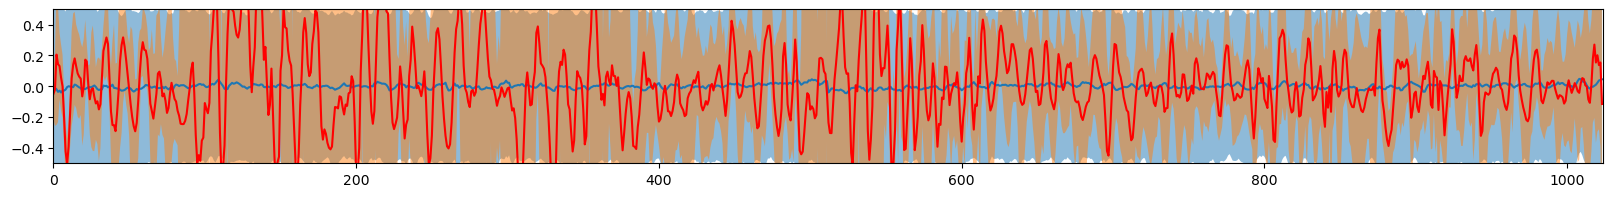

In [60]:
plt.figure(figsize=(20, 2))
ch = 5
real_data_avg = x[:, :, ch].mean(axis=0)
fake_data_avg = x_gen[:, :, ch].mean(axis=0)
plt.plot(real_data_avg, label="Real")
plt.plot(fake_data_avg, label="Generated", color='red')

plt.fill_between(np.arange(time_dim), real_data_avg - x[:, :, 0].std(axis=0), real_data_avg + x[:, :, 0].std(axis=0), alpha=0.5)
plt.fill_between(np.arange(time_dim), fake_data_avg - x_gen[:, :, 0].std(axis=0), fake_data_avg + x_gen[:, :, 0].std(axis=0), alpha=0.5)

plt.xlim([0, time_dim])
plt.ylim([-0.5, 0.5])

## Figure 2.1

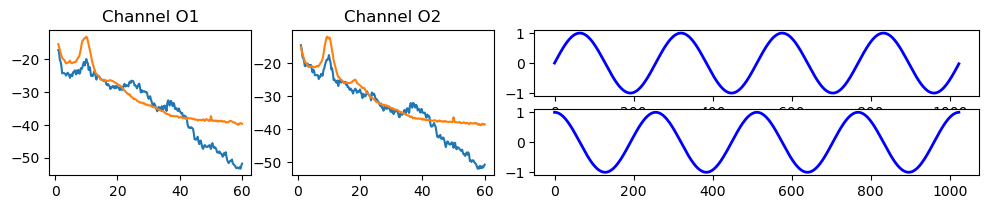

In [86]:
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(6, 4, figure=fig, height_ratios=[1, 1, 1, 1, 1, 1], width_ratios=[1, 1, 1, 1])

x = np.arange(0, time_dim)
# First subplot
ax1 = fig.add_subplot(gs[:2, 0])
plot_psd_multi_channel(x_gen, c=0, label='generated', show=False, db=True, ax=ax1)
plot_psd_multi_channel(data['x'], c=0, label='real', show=False, db=True, ax=ax1)

ax2 = fig.add_subplot(gs[:2, 1])
plot_psd_multi_channel(x_gen, c=1, label='generated', show=False, db=True, ax=ax2)
plot_psd_multi_channel(data['x'], c=1, label='real', show=False, db=True, ax=ax2)

ax3 = fig.add_subplot(gs[0, 2:])
ax3.plot(x, np.sin(2*np.pi*x/256), label='Real', color='blue', linestyle='-', linewidth=2)

ax4 = fig.add_subplot(gs[1, 2:])
ax4.plot(x, np.cos(2*np.pi*x/256), label='Real', color='blue', linestyle='-', linewidth=2)

# plt.tight_layout()
plt.show()

In [155]:
x_sub = data['x'].flatten(0, 1).reshape(n_subject, -1, 8)

(0.0, 30720.0)

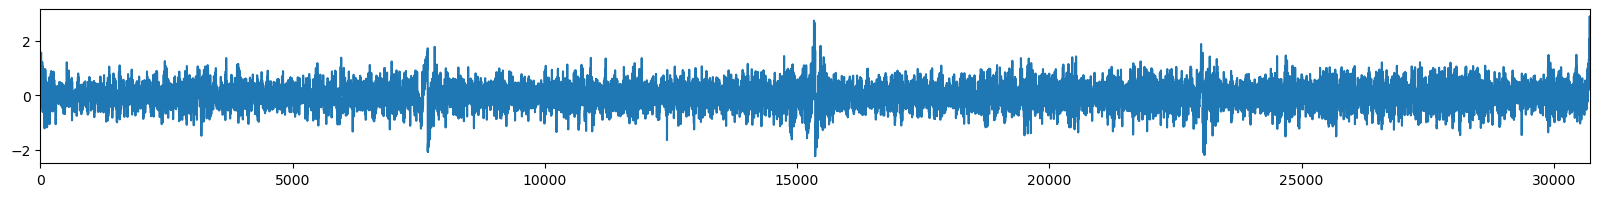

In [164]:
plt.figure(figsize=(20, 2))
plt.plot(x_sub.flatten(0, 1)[:30720, 0])
plt.xlim([0, 30720])

(0.0, 1500.0)

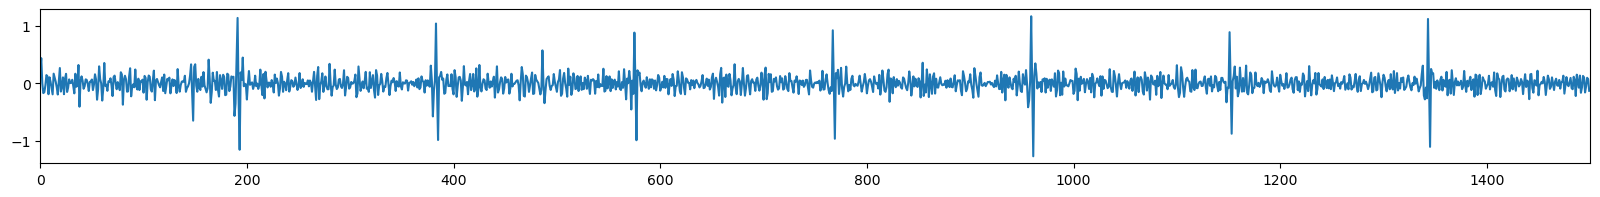

In [170]:
from scipy.ndimage import zoom

downsampled_signal = resample_poly(x_sub, up=1, down=40, axis=1)  # order=3 for cubic interpolation


plt.figure(figsize=(20, 2))
plt.plot(downsampled_signal[0, :1500, 0])
plt.xlim([0, 1500])


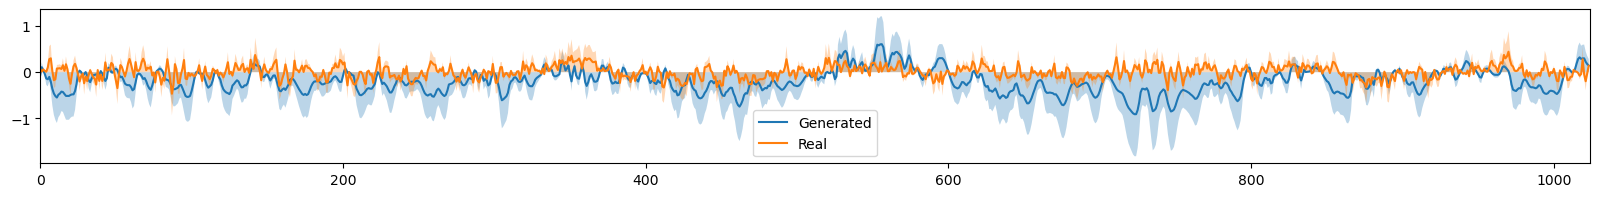

In [82]:
plt.figure(figsize=(20, 2))
plt.plot(x_gen[:, :, 0].mean(axis=0))
plt.plot(data['x'][:, :, 0].mean(axis=0))
plt.xlim([0, time_dim])

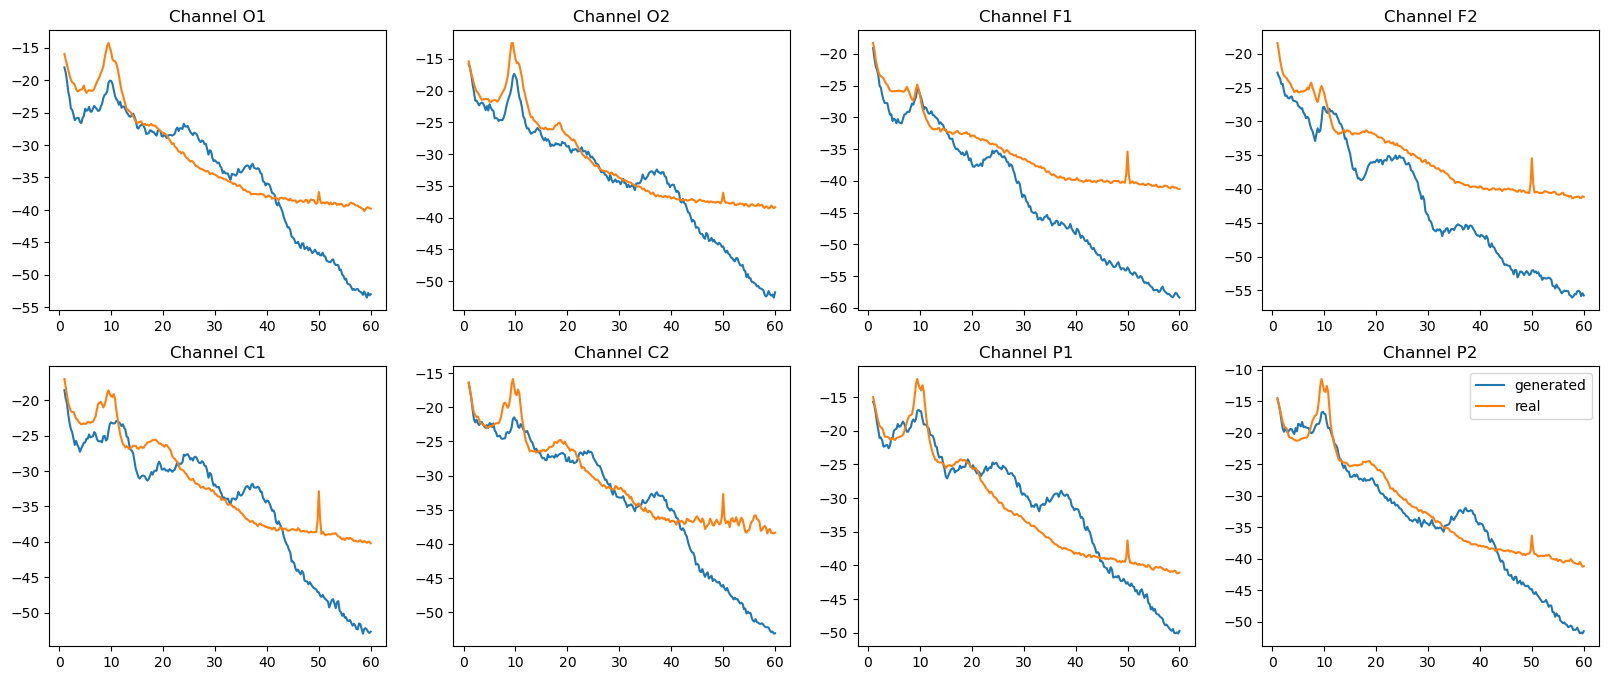

In [ ]:
# plot generated data
fig, axes = plt.subplots(4, 2, figsize=(20, 8))
for i in range(len(channels)):
    plot_psd_multi_channel(x_gen, c=i, label='generated', show=False, db=True, ax=axes[i//4, i%4])
    plot_psd_multi_channel(x[:1024], c=i, label='real', show=False, db=True, ax=axes[i//4, i%4])

plt.legend()
plt.show()